#### Goal
Goal of this notebook is to provide some visualizations for data inspection and feature engineering.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pd.set_option('display.float_format', lambda x: '%.5f' % x)
sns.set_style('darkgrid')

In [3]:
# Load in data
prop_df = pd.read_hdf('../data/processed/bexar_processed.h5')

##### Market Value

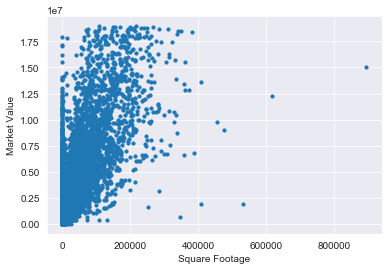

In [5]:
plt.scatter(x=prop_df.Sq_ft,y=prop_df.market_value,s=10)
plt.xlabel('Square Footage')
plt.ylabel('Market Value')
plt.show()

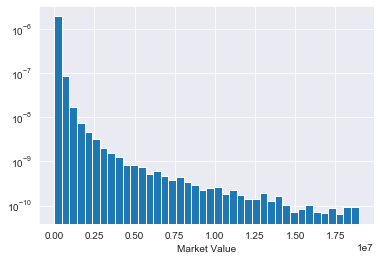

In [6]:
plt.hist(prop_df.market_value,density=True,bins=40,log=True)
plt.xlabel('Market Value')
plt.show()

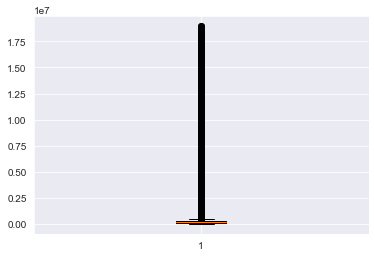

In [7]:
# Boxplot to see these outliers
plt.boxplot(prop_df.market_value)
plt.show()

#### Visualize Labeled Properties on Map

In [9]:
from keplergl import KeplerGl 
map_1 = KeplerGl(height=500)
map_1

User Guide: https://github.com/keplergl/kepler.gl/blob/master/docs/keplergl-jupyter/user-guide.md


KeplerGl(height=500)